En este caso, llevaremos a cabo un recorrido exhaustivo de un problema de ciencia de datos de clasificación binaria. Nuestro objetivo es combinar las diversas técnicas de pre-modelado que hemos aprendido con la validación cruzada para afinar un modelo de regresión logística.
Además, introducimos varias métricas (ROC/AUC) para evaluar el rendimiento de nuestro modelo de clasificación, que es intrínsecamente diferente de los anteriores modelos de regresión lineal que hemos encontrado. Este objetivo puede parecer un poco intimidante o técnico, pero al final del caso, todos estos términos deberían estar claros para usted.

In [1]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Contexto

Los bancos comerciales tradicionales no solían basarse en modelos estadísticos para decidir si debían emitirse préstamos personales, aunque esto está cambiando rápidamente en la actualidad. Usted es un científico de datos que trabaja en un banco comercial moderno. Su equipo de ciencia de datos ya ha construido modelos de regresión sencillos para predecir la probabilidad de que esos préstamos sean incumplidos. Sin embargo, ha observado que muchos de estos modelos funcionan mucho peor en producción que en las pruebas.

Su tarea consiste en crear un modelo de probabilidad de incumplimiento que le resulte cómodo poner en producción.

El conjunto de datos contiene los detalles de 5.000 solicitudes de préstamo que han sido emitidas previamente por su banco. Para cada préstamo, también se dispone del estado final del mismo (es decir, si el préstamo ha entrado en mora):
El archivo "loan_light.csv" contiene los detalles de 5000 préstamos
El archivo "loan_param.xlsx" contiene la descripción de cada covariable
El caso se desarrollará de la siguiente manera: 1) realizará una exploración de los datos para determinar las transformaciones adecuadas de las variables; 2) ajustará algunos modelos simples; 3) aprenderá sobre la validación cruzada y la utilizará para seleccionar el mejor modelo simple; y finalmente 4) construirá responsablemente modelos más complejos utilizando la validación cruzada.

## Ejericios

1. Cargue los datos y el diccionario de variables.

In [2]:
#Cargar csv

data = pd.read_csv("loan_light.csv")

#pista para diccionario
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})





,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


In [3]:
data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
0,80000.0,Individual,6746.0,0.0,0.0,15.12,10,B,1.0,743.75,...,1.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2016,1,principal
1,60000.0,Individual,13623.0,0.0,0.0,12.32,7,D,0.0,286.73,...,3.0,0.0,MORTGAGE,60,1.0,0.0,credit_card,2017,0,other
2,78000.0,Individual,11011.0,0.0,0.0,25.00,1,D,6.0,869.66,...,4.0,0.0,MORTGAGE,60,3.0,0.0,debt_consolidation,2015,0,analyst
3,62000.0,Individual,9679.0,0.0,0.0,22.32,9,D,7.0,713.96,...,2.0,0.0,RENT,36,4.0,0.0,debt_consolidation,2017,1,other
4,49000.0,Individual,4925.0,0.0,0.0,32.43,10,D,0.0,366.51,...,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,1,driver


2. Cree un gráfico de barras que muestre el número de préstamos que han entrado en mora y los que no.

<AxesSubplot:xlabel='loan_default', ylabel='count'>

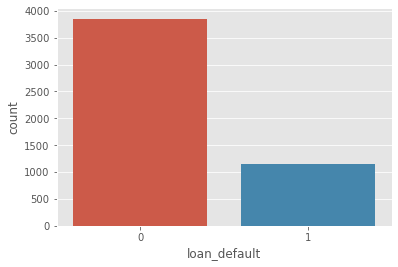

In [4]:

sns.countplot(x='loan_default', data=data)


3. Crea un histograma de los ingresos anuales y describelo.

<AxesSubplot:xlabel='annual_inc', ylabel='Count'>

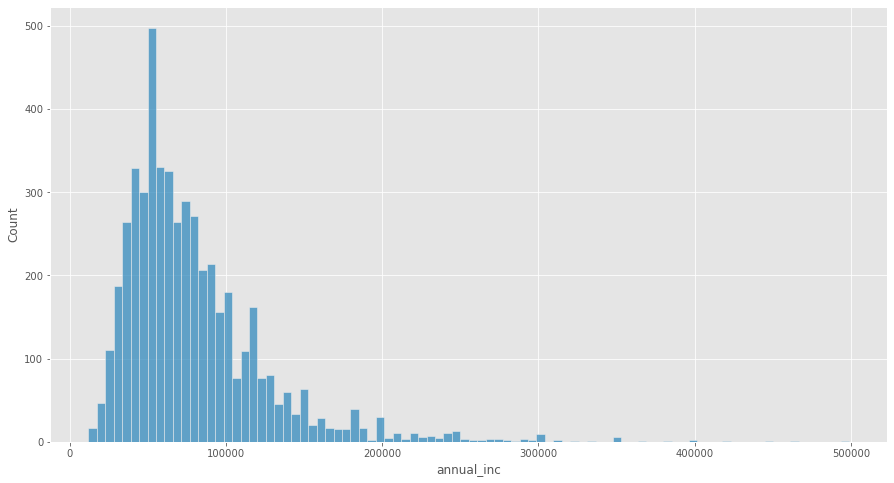

In [5]:
plt.figure(figsize = (15,8))
sns.histplot(data=data, x="annual_inc")

R// Se puede observar que las personas con bajos ingresos son las que mas solicitan prestamos; las personas con un ingreso de menos de $200.000.

4. Explora la asociación entre los ingresos anuales y la cuota mensual (scatterplot).

<AxesSubplot:xlabel='annual_inc', ylabel='installment'>

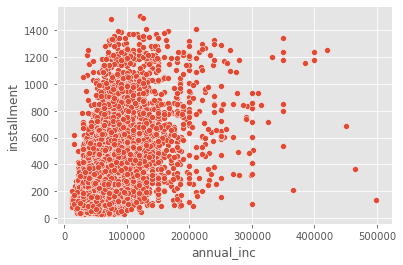

In [6]:
sns.scatterplot(data=data, x="annual_inc", y="installment")   

R// No hay ninguna asocacion.  Porque vemos que algunas personas con pocos ingresos tienen cuotas tanto altas como bajas y lo mismo resulta para la personas con ingresos mas elevados.

5. Visualice la matriz de correlación en todas las características numéricas utilizando el comando sns.heatmap()

<AxesSubplot:>

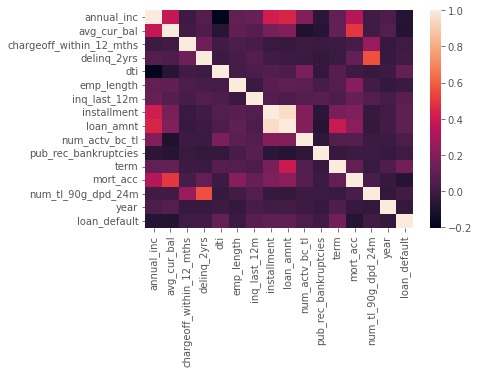

In [7]:
sns.heatmap(data.corr())

R// Se puede observar que casi no hay correlacion entre las variables, pero la variable installment y loam_amnt tiene la correcion mas positiva. 

6. Cree un modelo básico de regresión logística para predecir el incumplimiento del préstamo con una sola característica: installment. Llame a este modelo modelo1. Utilice una división 70/30 de los datos entre el entrenamiento y la prueba.

In [8]:
installment = data[["installment","loan_default"]]
installment

,installment,loan_default
0,743.75,1
1,286.73,0
2,869.66,0
3,713.96,1
4,366.51,1
...,...,...
4995,49.46,0
4996,155.51,0
4997,250.66,0
4998,69.38,0


In [9]:
X = installment[["installment"]]
y = installment["loan_default"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

7. Trace la curva [ROC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) del modelo1 y encuentre el área bajo la curva.

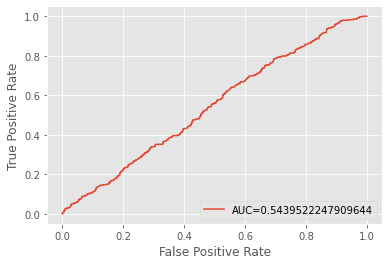

In [12]:
#pista
from sklearn import metrics
y_pred_prob = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

R//  Como el AUC  es del 56%, el modelo no esta clasificando bien teniendo encuenta solo la variable installemt. No dice mucho sobre como podemos clasificar las personas. 

8. Cree un modelo básico de regresión logística para predecir el incumplimiento del préstamo solo con las caracteristicas numericas. Llame a este modelo modelo2. Utilice una división 70/30 de los datos entre el entrenamiento y la prueba.

In [13]:
dataNumeric =  data._get_numeric_data()
dataNumeric

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,year,loan_default
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,0.0,36,0.0,0.0,2016,1
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,0.0,60,1.0,0.0,2017,0
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,0.0,60,3.0,0.0,2015,0
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,0.0,36,4.0,0.0,2017,1
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,0.0,36,0.0,0.0,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,90000.0,47759.0,0.0,0.0,15.88,3,3.0,49.46,1600,1.0,0.0,36,3.0,0.0,2017,0
4996,43000.0,11702.0,0.0,0.0,14.09,10,1.0,155.51,5000,2.0,0.0,36,2.0,0.0,2016,0
4997,70000.0,16495.0,0.0,0.0,24.02,1,0.0,250.66,8000,2.0,0.0,36,1.0,0.0,2016,0
4998,50000.0,24012.0,0.0,0.0,17.33,4,1.0,69.38,2000,4.0,0.0,36,2.0,0.0,2017,0


In [14]:
XNumeric = dataNumeric.iloc[:, :-1]
XNumeric

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,year
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,0.0,36,0.0,0.0,2016
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,0.0,60,1.0,0.0,2017
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,0.0,60,3.0,0.0,2015
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,0.0,36,4.0,0.0,2017
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,0.0,36,0.0,0.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,90000.0,47759.0,0.0,0.0,15.88,3,3.0,49.46,1600,1.0,0.0,36,3.0,0.0,2017
4996,43000.0,11702.0,0.0,0.0,14.09,10,1.0,155.51,5000,2.0,0.0,36,2.0,0.0,2016
4997,70000.0,16495.0,0.0,0.0,24.02,1,0.0,250.66,8000,2.0,0.0,36,1.0,0.0,2016
4998,50000.0,24012.0,0.0,0.0,17.33,4,1.0,69.38,2000,4.0,0.0,36,2.0,0.0,2017


In [15]:
yNumeric = dataNumeric.iloc[:,-1]
yNumeric

0       1
1       0
2       0
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: loan_default, Length: 5000, dtype: int64

In [16]:
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(XNumeric, yNumeric, test_size=0.3)

In [17]:
model2 = LogisticRegression()
model2.fit(X_train_numeric, y_train_numeric)

LogisticRegression()

9. Trace la curva ROC del modelo2 y encuentre el área bajo la curva. Es mejor modelo?

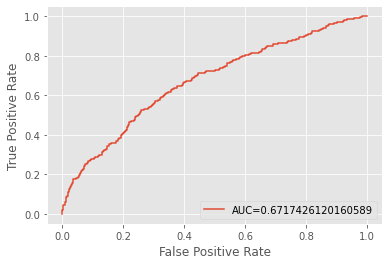

In [18]:
from sklearn import metrics
y_pred_prob = model2.predict_proba(X_test_numeric)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_numeric,  y_pred_prob)
auc = metrics.roc_auc_score(y_test_numeric, y_pred_prob)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

R// Mejoro!!!

10. Cree un modelo básico de regresión logística para predecir el incumplimiento del préstamo con las caracteristicas numericas, y agregue algunas categoricas (get_dummies()). Llame a este modelo modelo3. Utilice una división 70/30 de los datos entre el entrenamiento y la prueba. 

In [19]:
dataDummies =pd.get_dummies(data)
yDummies = dataDummies["loan_default"]
dataDummies=dataDummies.drop(['loan_default'], axis=1)
XDummies = dataDummies
dataDummies

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,...,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,...,0,0,0,0,0,0,0,0,0,0
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,...,0,0,0,0,0,0,0,0,0,0
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,...,0,0,0,0,0,0,0,0,0,0
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,...,0,0,0,0,0,0,0,0,0,0
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,90000.0,47759.0,0.0,0.0,15.88,3,3.0,49.46,1600,1.0,...,0,0,0,0,0,0,0,0,0,0
4996,43000.0,11702.0,0.0,0.0,14.09,10,1.0,155.51,5000,2.0,...,0,0,0,0,0,0,0,0,0,0
4997,70000.0,16495.0,0.0,0.0,24.02,1,0.0,250.66,8000,2.0,...,0,0,0,0,0,0,0,0,0,0
4998,50000.0,24012.0,0.0,0.0,17.33,4,1.0,69.38,2000,4.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(XDummies, yDummies, test_size=0.3)

In [21]:
model3 = LogisticRegression()
model3.fit(X_train_dummies, y_train_dummies)

LogisticRegression()

11. Trace la curva ROC del modelo3, y encuentre el área bajo la curva. Mejora el modelo agregando variables categoricas?

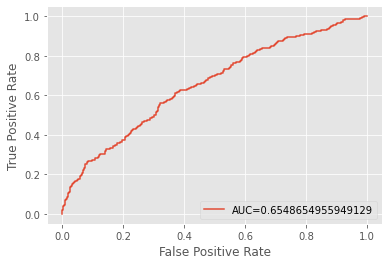

In [22]:
from sklearn import metrics
y_pred_prob = model3.predict_proba(X_test_dummies)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_dummies,  y_pred_prob)
auc = metrics.roc_auc_score(y_test_dummies, y_pred_prob)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

R// Es mejor que el primer modelo, pero no mejor que el segundo!